In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm import tqdm_notebook as tqdm
from sim_modules.testfuncs import gen_in_out_one_in_subs

In [970]:
class RNN():
    
    def __init__(self,**kwargs):
        
        self.N = kwargs.get('N',1000)
        self.cf = kwargs.get('cf',.1)
        self.cf_in = kwargs.get('cf_in',1.)
        self.a_r = np.ones((self.N)) * kwargs.get('a_r',1.)
        self.a_e = np.ones((self.N)) * kwargs.get('a_e',1.)
        self.b = np.ones((self.N)) * kwargs.get('b',0.)
        
        self.tau = 1.*kwargs.get('tau',1.)
        
        self.dim_in = kwargs.get('dim_in',1)
        self.dim_out = kwargs.get('dim_out',1)
        
        self.eps_a_r = np.ones((self.N)) * kwargs.get('eps_a_r',0.001)
        self.eps_a_e = np.ones((self.N)) * kwargs.get('eps_a_e',0.001)
        self.eps_w_out = np.ones((self.dim_out,self.N+1))
        self.eps_w_out[:,0] *= 1.
        self.eps_w_out *= kwargs.get('eps_w_out',0.001)
        self.eps_b = np.ones((self.N)) * kwargs.get('eps_b',0.0001)
        
        self.y_mean_target = np.ones((self.N)) * kwargs.get('y_mean_target',.5)
                
        self.W = np.random.normal(0.,1./(self.N*self.cf)**.5,(self.N,self.N))*(np.random.rand(self.N,self.N) <= self.cf)
        self.W[range(self.N),range(self.N)] = 0.
        
        self.w_in = np.random.normal(0.,1.,(self.N,self.dim_in))
        self.w_out = np.random.rand(self.dim_out,self.N+1)*0.01
        self.w_out[:,0] = 0.
    
    def f(self,x):
        #return (np.tanh(2.*x)+1.)/2.
        return np.tanh(x)
    
    def df_x(self,x):
        f = self.f(x)
        #return 4.*f*(1.-f)
        return f*(1.-f)
        
    def df_y(self,y):
        #return 4.*y*(1.-y)
        return 1.-y**2.
    
    def check_data_in_comp(self,data):

        if len(data.shape)==1:
            if self.dim_in != 1:
                print("input dimensions do not fit!")
                sys.exit()
            return np.array([data]).T

        elif (len(data.shape)>2) or (data.shape[1] != self.dim_in):
            print("input dimensions do not fit!")
            sys.exit()

        return data

    def check_data_out_comp(self,data):

        if len(data.shape)==1:
            if self.dim_out != 1:
                print("output dimensions do not fit!")
                #sys.exit()
            return np.array([data]).T

        elif (len(data.shape)>2) or (data.shape[1] != self.dim_out):
            print("output dimensions do not fit!")
            #sys.exit()

        return data
    
    def run_hom(self,u_in,show_progress=True):
        
        u_in = self.check_data_in_comp(u_in)
        
        T = u_in.shape[0]
        
        y = np.ndarray((T,self.N))
        b = np.ndarray((T,self.N))
        
        y[0,:] = self.f(self.a_e*(self.w_in @ u_in[0,:]) - self.b)
        b[0,:] = self.b
        
        for t in tqdm(range(1,T),disable=not(show_progress)):
            
            y[t,:] = self.f(self.a_r * (self.W @ y[t-1,:]) + self.a_e * (self.w_in @ u_in[t,:]) - self.b)
            self.b += self.eps_b*(y[t,:] - self.y_mean_target)
            
            b[t,:] = self.b
            
        return y, b
    
    def learn_w_out_trial(self,u_in,u_target,reg_fact=.01,show_progress=False):
        
        u_in = self.check_data_in_comp(u_in)
        u_target = self.check_data_out_comp(u_target)
        
        n_t = u_in.shape[0]
        
        
        y = np.ndarray((n_t,self.N+1))
        y[:,0] = 1.

        
        y[0,1:] = self.f(self.a_e*(self.w_in @ u_in[0,:]) - self.b)


        for t in tqdm(range(1,n_t),disable=not(show_progress)):

            y[t,1:] = self.f(self.a_r*(self.W.dot(y[t-1,1:])) + self.a_e*(self.w_in @ u_in[t,:]) - self.b)

        self.w_out[:,:] = (np.linalg.inv(y.T @ y + reg_fact*np.eye(self.N+1)) @ y.T @ u_target).T
        
    
    def run_learn(self,u_in,u_out,T_skip_rec = 1,show_progress=True):
        
        u_in = self.check_data_in_comp(u_in)
        u_out = self.check_data_out_comp(u_out)
        
        T = u_in.shape[0]
        
        T_rec = int(T/T_skip_rec)
        
        #### Recorders
        y_rec = np.ndarray((T_rec,self.N+1))
        X_r_rec = np.ndarray((T_rec,self.N))
        X_e_rec = np.ndarray((T_rec,self.N))
        O_rec = np.ndarray((T_rec,self.dim_out))
        err_rec = np.ndarray((T_rec,self.dim_out))
        a_r_rec = np.ndarray((T_rec,self.N))
        a_e_rec = np.ndarray((T_rec,self.N))
        delta_a_r_rec = np.ndarray((T_rec))
        delta_a_e_rec = np.ndarray((T_rec))
        w_out_rec = np.ndarray((T_rec,self.dim_out,self.N+1))
        ####
        
        y = np.ndarray((self.N+1))
        y[0] = 1.
        
        X_r = np.ndarray((self.N))
        X_e = np.ndarray((self.N))
        
        O = np.ndarray((self.dim_out))
        
        err = np.ndarray((self.dim_out))
        
        sign_err = np.ndarray((self.dim_out))
        
        dyda_r = np.zeros((self.N))
        dyda_e = np.zeros((self.N))
        
        delta_a_r = 0.#np.ndarray((self.N))
        delta_a_e = 0.#np.ndarray((self.N))
        
        delta_w_out = np.ndarray((self.dim_out,self.N+1))
        
        X_r[:] = 0.
        X_e[:] = self.w_in @ u_in[0,:]
        
        y[1:] = self.f(self.a_r * X_r + self.a_e * X_e - self.b)
        
        O[:] = self.w_out @ y
        err[:] = O - u_out[0,:]
        
        #### Assign for t=0
        y_rec[0,:] = y
        X_r_rec[0,:] = X_r
        X_e_rec[0,:] = X_e 
        O_rec[0,:] = O
        err_rec[0,:] = err
        a_r_rec[0,:] = self.a_r 
        a_e_rec[0,:] = self.a_e
        w_out_rec[0,:,:] = self.w_out
        delta_a_r_rec[0] = 0.
        delta_a_e_rec[0] = 0.
        ####
        
        for t in tqdm(range(1,T),disable=not(show_progress)):
            
            X_r = self.W @ y[1:]
            X_e = self.w_in @ u_in[t,:]
            
            y[1:] = self.f(self.a_r * X_r + self.a_e * X_e - self.b)
            
            #### calc err
            O = self.w_out @ y
            err = O - u_out[t,:]

            sign_err = 2.*(err > 0.) - 1.
            ####
            
            #### update gains
            #dyda_r = self.df_y(y[1:])*(X_r + self.a_r[0]*self.W @ dyda_r)
            #dyda_e = self.df_y(y[1:])*(X_e + self.a_e[0]*self.W @ dyda_e)
            
            dyda_r = self.df_y(y[1:])*X_r
            dyda_e = self.df_y(y[1:])*X_e
            
            #delta_a_r = -(self.w_out[:,1:].T @ err) * self.df_y(y[1:]) * X_r
            #delta_a_e = -(self.w_out[:,1:].T @ err) * self.df_y(y[1:]) * X_e
            
            delta_a_r = -(err * (self.w_out[:,1:] @ dyda_r)).sum()
            delta_a_e = -(err * (self.w_out[:,1:] @ dyda_e)).sum()
            
            self.a_r += self.eps_a_r * delta_a_r
            self.a_e += self.eps_a_e * delta_a_e
            
            self.a_r = np.maximum(0.01,self.a_r)
            self.a_e = np.maximum(0.01,self.a_e)
            ####
            
            #### update readout weights
            delta_w_out = np.outer(err,y)
            self.w_out += -self.eps_w_out * delta_w_out
            
            #self.w_out[:,1:] = np.maximum(0.,self.w_out[:,1:])
            ####
            
            #### record
            if t%T_skip_rec == 0:
                
                t_rec = int(t/T_skip_rec)

                y_rec[t_rec,:] = y
                X_r_rec[t_rec,:] = X_r
                X_e_rec[t_rec,:] = X_e 
                O_rec[t_rec,:] = O
                err_rec[t_rec,:] = err
                a_r_rec[t_rec,:] = self.a_r 
                a_e_rec[t_rec,:] = self.a_e
                delta_a_r_rec[t_rec] = delta_a_r
                delta_a_e_rec[t_rec] = delta_a_e                
                w_out_rec[t_rec,:,:] = self.w_out
        
        t_ax = np.array(range(T_rec))*T_skip_rec
        
        return t_ax,y_rec,X_r_rec,X_e_rec,O_rec,err_rec,w_out_rec,a_r_rec,a_e_rec,delta_a_r_rec,delta_a_e_rec
    
    def predict_data(self,data,return_reservoir_rec=False,show_progress=True):

        data = self.check_data_in_comp(data)

        n_t = data.shape[0]

        u_in = data

        y = np.ndarray((n_t,self.N+1))
        y[:,0] = 1.

        y[0,1:] = self.f(self.a_e*(self.w_in @ u_in[0,:]) - self.b)

        for t in tqdm(range(1,n_t),disable=not(show_progress)):

            y[t,1:] = self.f(self.a_r*(self.W.dot(y[t-1,1:])) + self.a_e*(self.w_in @ u_in[t,:]) - self.b)

        out = (self.w_out @ y.T).T
        if self.dim_out == 1:
            out = out[:,0]

        if return_reservoir_rec:
            return (out,y)
        else:
            return out

In [979]:
n_sweep = 15

a_r_range = np.linspace(0.,1.2,n_sweep+1)
a_e_range = np.linspace(0.,1.2,n_sweep+1)

err_sweep = np.ndarray((n_sweep,n_sweep))
grad_sweep = np.ndarray((n_sweep,n_sweep,2))

tau_task = 10
y_target = 0.5


for k in tqdm(range(n_sweep)):
    for l in tqdm(range(n_sweep),disable=True):

        rnn = RNN(N=500,a_e =a_e_range[l],a_r =a_r_range[k],
                  eps_a_r=0.,eps_a_e=0.,eps_w_out=0.,
                  y_mean_target=y_target)
        #u_in, u_out = gen_in_out_one_in_subs(3000,tau_task)
        #u_in = np.zeros(3000)
        #y,b = rnn.run_hom(u_in,show_progress=False)

        u_in, u_out = gen_in_out_one_in_subs(5000,tau_task)
        rnn.learn_w_out_trial(u_in,u_out,show_progress=False)

        u_in_test, u_out_test = gen_in_out_one_in_subs(2000,tau_task)
        u_pred = rnn.predict_data(u_in_test,show_progress=False)
    
        u_in_grad, u_out_grad = gen_in_out_one_in_subs(30000,tau_task)
        t,y,X_r,X_e,O,err,w_out,a_r,a_e,delta_a_r,delta_a_e = rnn.run_learn(u_in_grad,u_out_grad,show_progress=False)
        
        grad_sweep[k,l,:] = np.array([delta_a_e.mean(),delta_a_r.mean()])        
        err_sweep[k,l] = ((u_out_test-u_pred)**2.).mean()
        

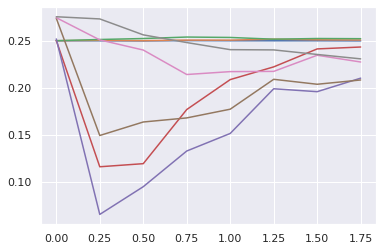

In [868]:
plt.plot(a_r_range[:-1],err_sweep.T)
plt.show()

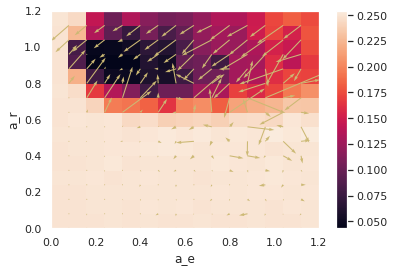

In [980]:
plt.pcolormesh(a_e_range,a_r_range,err_sweep)
plt.xlabel("a_e")
plt.ylabel("a_r")
plt.colorbar()
plt.quiver(a_e_range[:-1], a_r_range[:-1], grad_sweep[:,:,0], grad_sweep[:,:,1],color='y')
plt.show()

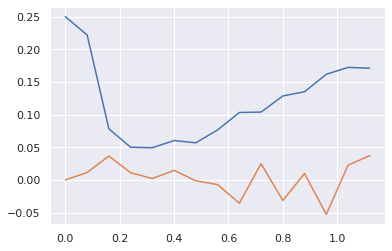

In [982]:
plt.plot(a_e_range[:-1],err_sweep[10,:])
plt.plot(a_e_range[:-1],grad_sweep[10,:,0])
plt.show()

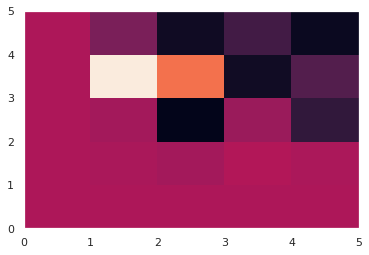

In [978]:
plt.pcolormesh(grad_sweep[:,:,0])
plt.show()

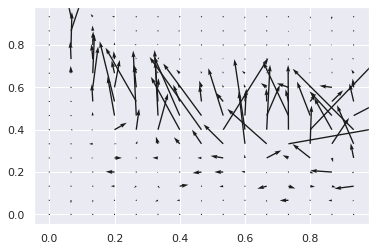

In [948]:
plt.quiver(a_e_range[:-1], a_r_range[:-1], grad_sweep[:,:,0], grad_sweep[:,:,1])
plt.show()

In [801]:
rnn = RNN(N=500,a_e =a_e_range[l],a_r =a_r_range[k],eps_b=0.05,eps_a_r=.5,eps_a_e=.5,eps_w_out=.01,y_mean_target=0.4)

u_in, u_out = gen_in_out_one_in_subs(10000,10)
y,b = rnn.run_hom(u_in)

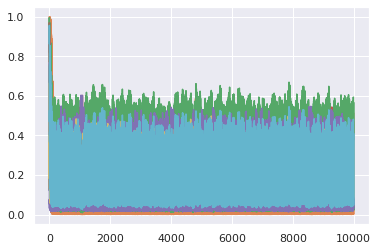

In [802]:
plt.plot(y[:,:10])
plt.show()

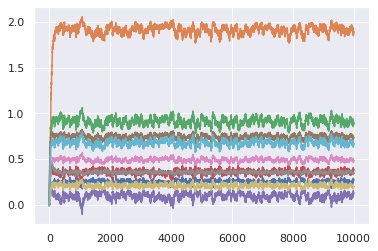

In [803]:
plt.plot(b[:,:10])
plt.show()

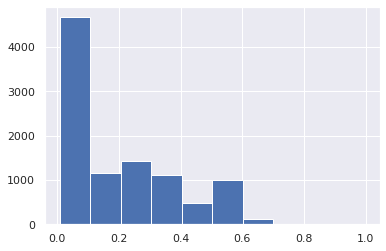

In [804]:
plt.hist(y[:,2])
plt.show()

In [805]:
u_in, u_out = gen_in_out_one_in_subs(10000,6)
rnn.learn_w_out_trial(u_in,u_out,show_progress=True)

u_in, u_out = gen_in_out_one_in_subs(150000,6)
t_ax,y,X_r,X_e,O,err,w_out,a_r,a_e = rnn.run_learn(u_in,u_out,T_skip_rec=20)

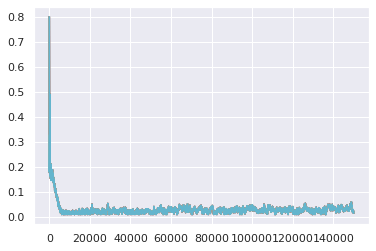

In [806]:
plt.plot(t_ax,a_r[:,:10])
#plt.plot(t_ax,((a_r**2.).sum(axis=1)/rnn.N)**.5,'--',c='k')
plt.show()

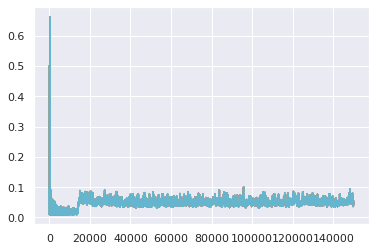

In [807]:
plt.plot(t_ax,a_e[:,:10])
plt.show()

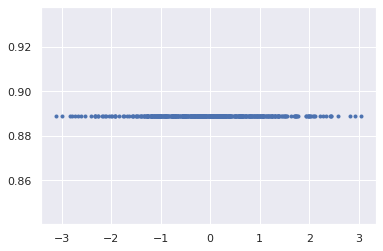

In [683]:
plt.plot(rnn.w_in[:,0],a_e[-1,:],'.')
plt.show()

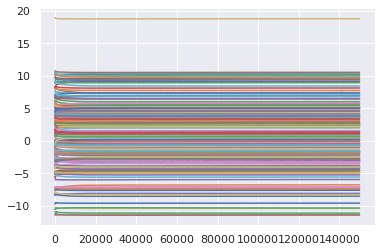

In [808]:
plt.plot(t_ax[:],w_out[:,0,:150])
plt.show()

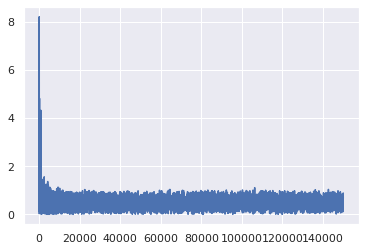

In [809]:
plt.plot(t_ax,np.abs(err))
#plt.yscale("log")
plt.show()

In [799]:
np.abs(err[1:]).mean()

0.0056414588768551824